In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

from sims_backend import operations

# QuTip integration settings
options = qt.Options()
options.num_cpus = 5
options.nsteps = 1000000

# Initialisation Parameters
nIons = 2
nModes = 1
nMax = 100
rabi = 2 * np.pi * 0.5
eta = 0.1

op = operations(nIons, nModes, nMax, rabi, eta)

### Rudimentary MS Gate: One Mode and Two Ions

In [2]:
# System Properties
freq_mode = 0
detuning = 1.0

# Simulation Parameters
t = np.linspace(0, 10, 101)
psi0 = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), qt.basis(nMax, 0))

args = {
    'freq_mode0': 2 * np. pi * freq_mode,

    "detuning_ion0": 0.0,
    "detuning_rsb_ion0": -2 * np.pi * detuning,
    "detuning_bsb_ion0": 2 * np.pi * detuning,
    "phase_ion0": 0.0,
    
    "detuning_ion1": 0.0,
    "detuning_rsb_ion1": -2 * np.pi * detuning,
    "detuning_bsb_ion1": 2 * np.pi * detuning,
    'phase_ion1': 0.0
}

# Hamiltonians
carrier_ion0 = op.def_carrier_hamiltonian(index = 0)
bsb_ion0_mode0 = op.def_bsb_hamiltonian(index_ion = 0, index_mode = 0)
rsb_ion0_mode0 = op.def_rsb_hamiltonian(index_ion = 0, index_mode = 0)

carrier_ion1 = op.def_carrier_hamiltonian(index = 1)
bsb_ion1_mode0 = op.def_bsb_hamiltonian(index_ion = 1, index_mode = 0)
rsb_ion1_mode0 = op.def_rsb_hamiltonian(index_ion = 1, index_mode = 0)

H = bsb_ion0_mode0 + rsb_ion0_mode0 + bsb_ion1_mode0 + rsb_ion1_mode0

# Projective Measurements
measure_gg = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.ket2dm(qt.basis(2, 0)))
measure_ee = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.basis(2, 1)))

measure_ge = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.ket2dm(qt.basis(2, 1)))
measure_eg = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.basis(2, 0)))

# Single-Party Measurements
e_ops = [
    op.a[0].dag() * op.a[0],
    op.sM[0].dag() * op.sM[0],
    op.sM[1].dag() * op.sM[1]
]

' ax2 = ax.twinx()\nax2.plot(t, n_phonon, \'r\', linestyle = \'dashed\', label = \'phonon\')\nax2.set_ylabel("Phonon Population")\n\nax2.set_ylim([0, np.max(n_phonon)])\nax2.legend(loc = \'upper right\') '

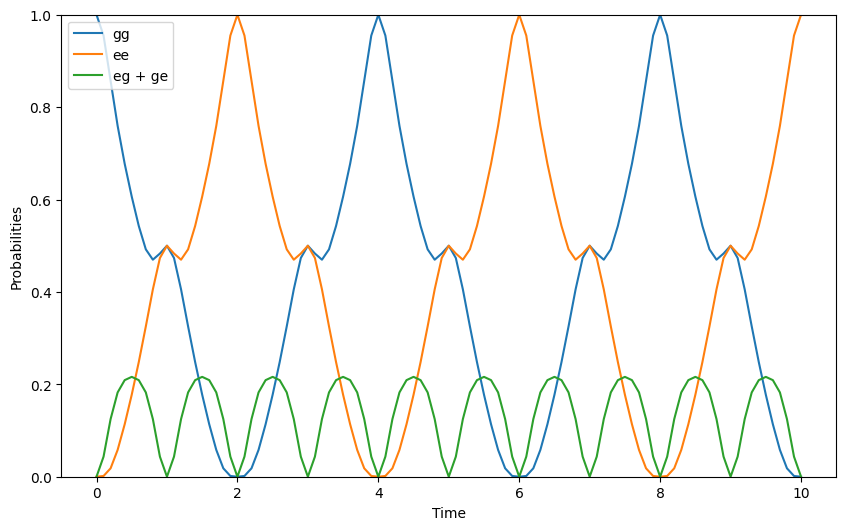

In [3]:
output = qt.sesolve(H = H, psi0 = psi0, tlist = t, args = args) 
gg = []
ee = []
eg = []
ge = []
p = []

for r in output.states:
    r = r.unit()
    q = qt.ptrace(r, [0, 1]).unit()

    val, states, prob = qt.measurement.measurement_statistics(q, measure_ee)
    for i in range(len(states)):
        if states[i] == measure_gg:
            gg.append(prob[i])
        elif states[i] == measure_ee:
            ee.append(prob[i])
        elif states[i] == measure_eg:
            eg.append(prob[i])
        elif states[i] == measure_ge:
            ge.append(prob[i])

results = qt.sesolve(H = H, psi0 = psi0, tlist = t, e_ops = e_ops, args = args) 
n_phonon = results.expect[0]
n_ion0 = results.expect[1]
n_ion1 = results.expect[2]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(t, gg, '-', label="gg")
ax.plot(t, ee, '-', label="ee")
ax.plot(t, [eg[i] + ge[i] for i in range(len(eg))], '-', label="eg + ge")

#ax.plot(t, n_ion0, label = 'Ion0')
#ax.plot(t, n_ion1, label = 'Ion1')

ax.set_ylabel("Probabilities")
ax.set_xlabel("Time")
ax.legend(loc = 'upper left')
ax.set_ylim([0, 1.0])

""" ax2 = ax.twinx()
ax2.plot(t, n_phonon, 'r', linestyle = 'dashed', label = 'phonon')
ax2.set_ylabel("Phonon Population")

ax2.set_ylim([0, np.max(n_phonon)])
ax2.legend(loc = 'upper right') """

#### Generate Symmetric Detuning vs Gate Time 2D plot with P(gg) = P(ee) and P(eg + ge) minimum lines

In [70]:
ls_detuning = np.linspace(0.8, 1.2, 200)
ls_gatetime = np.linspace(0.8, 1.2, 200)

arr_p0_p2 = np.empty([len(ls_detuning), len(ls_gatetime)])
arr_p1 = np.empty([len(ls_detuning), len(ls_gatetime)])

In [71]:
for i in range(len(ls_detuning)):
    for j in range(len(ls_gatetime)):
        t = [0, ls_gatetime[j]]

        args["detuning_rsb_ion0"] = -2 * np.pi * ls_detuning[i]
        args["detuning_bsb_ion0"] = 2 * np.pi * ls_detuning[i]
        args["detuning_rsb_ion1"] = -2 * np.pi * ls_detuning[i]
        args["detuning_bsb_ion1"] = 2 * np.pi * ls_detuning[i]

        r = qt.sesolve(H = H, psi0 = psi0, tlist = t, args = args).states[-1]
        q = qt.ptrace(r, [0, 1]).unit()

        val, states, prob = qt.measurement.measurement_statistics(q, measure_ee)

        arr_p0_p2[i][j] = np.abs(prob[0] - prob[3])
        arr_p1[i][j] = prob[1] + prob[2]

In [72]:
arr_res = np.zeros([len(ls_detuning), len(ls_gatetime)])

for i in range(len(ls_detuning)):
    for j in range(len(ls_gatetime)):
        min_p0_p2 = np.argmin(arr_p0_p2[i])
        min_p1 = np.argmin(arr_p1[i])

    arr_res[i][min_p0_p2] = 1
    arr_res[i][min_p1] = -1

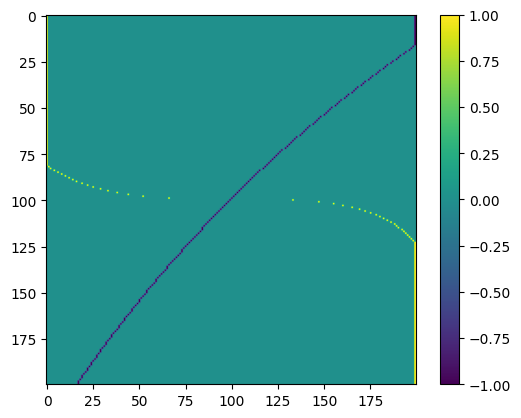

In [73]:
plt.imshow(arr_res)
plt.colorbar()
plt.show()

# CLEAN UP

In [ ]:
#https://www.nature.com/articles/s41467-018-08090-0  Mode Frequencies/LD params

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.integrate import quad

def eval_rabi_freq(nStart, nDelta, eta):
    """
    Calculates Rabi Frequency for nStart -> nStart + nDelta

    Args:
        nStart (int): Initial phonon state
        nDelta (int): Change in phonon number
        eta (float): Lamb-Dicke Parameter

    Returns:
        float: Rabi frequency
    """
    nEnd = nStart + nDelta

    nSmall = min([nStart, nEnd])
    nBig = max([nStart, nEnd])
    factor2 = np.exp(-0.5 * eta**2) * eta**(np.absolute(nDelta))
    factor3 = np.sqrt(np.math.factorial(nSmall)/np.math.factorial(nBig))
    factor4 = special.assoc_laguerre(eta**2, nSmall, np.absolute(nDelta))

    return factor2 * factor3 * factor4

def generate_ld_matrix(ld_param):
    """
    Generate 3x3 matrix containing the Lamb-Dicke parameters for 3 ions for the 3 modes of motion along each axis.
    
    Rows label modes
    Columns label the ions
    
    E.g) matrix[1][2]
        Row = 1 -> OP1 Mode
        Column = 2 -> 3rd Ion
    """
    matrix = np.empty([3, 3])
    
    for i in range(3):
        if i == 0: # Center-of-Mass Motion
            for j in range(3):
                matrix[i][j] = ld_param
        elif i == 1: # OP1
            matrix[i][0] = (ld_param * np.sqrt(3))/np.sqrt(2)
            matrix[i][1] = 0
            matrix[i][2] = (ld_param * np.sqrt(3))/np.sqrt(2)
        else:   # OP2
            matrix[i][0] = (ld_param * np.sqrt(3))/np.sqrt(6)
            matrix[i][1] = -2 * (ld_param * np.sqrt(3))/np.sqrt(6)
            matrix[i][2] = (ld_param * np.sqrt(3))/np.sqrt(6)
    
    return matrix

In [ ]:
# --------------------- Experimental Parameters (Based on Measurements on 6 December, 2023) --------------------

# --------------------- Mode Frequencies ---------------------
f0 = 112.94884

fAx_IP = np.average([f0 - 112.545007, 113.349302 - f0])
fAx_OP1 = np.average([f0 - 112.247337, 113.646767 - f0])
fAx_OP2 = np.average([f0 - 111.975974, 113.918956 - f0])

fAx = [fAx_IP, fAx_OP1, fAx_OP2]

fR1_IP = np.average([f0 - 111.855983, 114.038652 - f0])
fR1_OP1 = np.average([f0 - 111.933887, 113.960546 - f0])
fR1_OP2 = np.average([f0 - 112.059230, 113.835470 - f0])

fR1  = [fR1_IP, fR1_OP1, fR1_OP2]

fR2_IP = np.average([f0 - 111.573692, 114.321367 - f0])
fR2_OP1 = np.average([f0 - 111.636050, 114.258107 - f0])
fR2_OP2 = np.average([f0 - 111.730128, 114.163908 - f0])

fR2 = [fR2_IP, fR2_OP1, fR2_OP2]

# # --------------------- Rabi Frequencies (Carrier) ---------------------
ion1_rabi = np.pi/ 3.9
ion2_rabi = np.pi/ 3.0
ion3_rabi = np.pi/ 3.15

rabi_freq = [ion1_rabi, ion2_rabi, ion3_rabi]

# Carrier crosstalks (ct)
ct_1_2 = 0
ct_1_3 = 0

ct_2_1 = np.pi/ 13.8
ct_2_3 = 0

ct_3_1 = np.pi/ 38
ct_3_2 = np.pi/ 8.93

# Possible combinations of Rabi frequencies
opt_ion_1_2 = [ion1_rabi, ion2_rabi, 0.]
opt_ion_1_3 = [ion1_rabi, 0., ion3_rabi]
opt_ion_2_3 = [0., ion2_rabi, ion3_rabi]


# --------------------- Lamb-Dicke Parameteres --------------------
ax_LD = 0.26 # GUESSED (no data to infer from)

# To calculate LD param for radials (same value because same projection angle)
#   R1_OP1 has pi-time of 53.3 (Ion1), 54.1 (Ion3)
#   LD of OP1 is LD of IP * Sqrt(3/2)
#   Thus, Omega(R1_OP1) = Sqrt(3/2) * LD * Omega(Carrier)
#   Or, LD = Pi/tPi(R1_OP1) / Pi/(tPi(Carrier)) / (Sqrt(3/2))
r1_LD = (0.048 + 0.059)/2 
r2_LD = r1_LD

ax_ld = generate_ld_matrix(ax_LD)
r1_ld = generate_ld_matrix(r1_LD)
r2_ld = generate_ld_matrix(r2_LD)

#### Infidelity Calculations

For a MS interaction involving ground-state cooled motional modes, the infidelity is approximately given by:

$ F = \frac{4}{5} \sum_p (|\alpha_{i,p}|^2 + |\alpha_{j,p}|^2), \quad \alpha_{i, p} = \int^\tau_0 \Omega(t) \sin[\psi(t)] e^{i\omega_p t}, \quad \psi(t) = \int^t_0 \mu(t')dt' $

The index $i$ labels the ions, and $p$ the motional modes, with an associated mode frequency $\omega_p$. Here, $\tau$ is the gate time, and $\Omega(t)$ and $\mu(t')$ are the time-dependent Rabi frequency and detuning respectively.

In the most basic instance of the MS gate, both the Rabi frequency and detuning are constants in time. This simplifies the equation significantly:

$ F = \frac{4}{5} \sum_p (|\alpha_{i,p}|^2 + |\alpha_{j,p}|^2), \quad \alpha_{i, p} = \Omega \int^\tau_0 \sin(\mu t) e^{i\omega_p t} $

Because of the way the functions are defined, this calculation has to done separately for each Cartesian axis, then summed over all the axes in the end.

In [ ]:
def integrand_real(t, detuning, mode_frequency):
    return np.sin(2 * np.pi * detuning * t) * np.cos(2 * np.pi * mode_frequency * t) # Convert angular frequencies to normal frequency units

def integrand_img(t, detuning, mode_frequency):
    return np.sin(2 * np.pi * detuning * t) * np.sin(2 * np.pi * mode_frequency * t) # Convert angular frequencies to normal frequency units

def calc(gate_time, ls_detuning, ls_modefreq, ls_ld, target_ion):
    res = [[], [], []]

    for ion in target_ion:
        for i in range(3):
            detuning = ls_detuning[i]
            mode_frequency = ls_modefreq[i]

            relevant_ld = ls_ld[i][ion]
            
            realPart = quad(integrand_real, 0, gate_time, args = (detuning, mode_frequency), limit = 200)
            imgPart = quad(integrand_img, 0, gate_time, args = (detuning, mode_frequency), limit = 200)
            integration = realPart[0] + 1j * imgPart[0]

            res[ion].append(np.absolute(relevant_ld * rabi_freq[ion] * integration)**2)

    return res

def alpha(gate_time, detuning, target_mode, target_ion):

    # Initial sorting
    if 'IP' in target_mode:
        target_mode_index = 0
    elif 'OP1' in target_mode:
        target_mode_index = 1
    elif 'OP2' in target_mode:
        target_mode_index = 2
    else:
        print("IP, OP1, OP2 not in target_mode")
        return None
    
    if 'Ax' in target_mode:
        freq_ref = fAx[target_mode_index]
    elif 'R1' in target_mode:
        freq_ref = fR1[target_mode_index]
    elif 'R2' in target_mode:
        freq_ref = fR2[target_mode_index]
    else:
        print("Ax, R1, R2 not in taget_mode")
        return None
    
    laser_frequency = freq_ref + detuning
    
    # Axial Contributions
    fAx_detuning = [i - laser_frequency for i in fAx]
    resAx = calc(gate_time, fAx_detuning, fAx, ax_ld, target_ion)

    fR1_detuning = [i - laser_frequency for i in fR1]
    resR1 = calc(gate_time, fR1_detuning, fR1, r1_ld, target_ion)

    fR2_detuning = [i - laser_frequency for i in fR2]
    resR2 = calc(gate_time, fR2_detuning, fR2, r2_ld, target_ion)

    return resAx, resR1, resR2

In [ ]:
gate_time = 100

detuning = 17150 * 10**(-6) # Conver to MHz

resAx, resR1, resR2 = alpha(gate_time, detuning, 'R2_OP1', [0, 2])

print("Ax: " + str(resAx[0]))
print("R1: " + str(resR1[0]))
print("R2: " + str(resR2[0]))

infidelity = []

for res in [resAx, resR1, resR2]:
    for i in range(3):
        check = res[0][i] + res[2][i]
        infidelity.append(check)

print("Fidelity = ", np.round(1 - 4/5 * np.sum(infidelity), 3))